# 1주차 심화과제 - plot3

# Dropout을 적용한 이후의 generalization error 확인



GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다.

CIFAR10 데이터셋 다운로드

trainset, testset 다운로드

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170498071/170498071 [00:18<00:00, 9113955.40it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


데이터셋 데이터 확인

50000
torch.Size([3, 32, 32]) 6


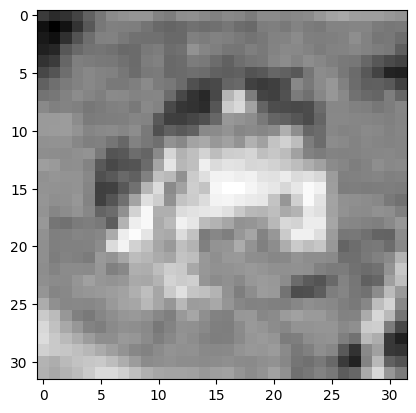

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')


다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# shuffle False 적용
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)


torch.Size([256, 3, 32, 32]) torch.Size([256])
torch.Size([256, 3, 32, 32]) torch.Size([256])


PyTorch dropout을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다.

Dropout 확률은 0.1로 설정합니다.

In [6]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    self.act = nn.LeakyReLU()
    # dropout 설정
    self.dropout = nn.Dropout(0.1)


  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.layer3(x)

    return x


model = Model(32 * 32 * 3, 128)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [7]:
from torch.optim import SGD,Adam

lr = 0.001

model = model.to('cuda')
# adam으로 설정
optimizer = Adam(model.parameters(), lr=lr)

# TEST, TRAIN accuracy 측정

Epoch   0 | Train Accuracy: 49.2800% | Test Accuracy: 47.9700%
Epoch   0 | Train Loss: 0.5909% | Test Loss: 0.1177%
Epoch   1 | Train Accuracy: 49.7000% | Test Accuracy: 48.1200%
Epoch   1 | Train Loss: 0.5809% | Test Loss: 0.1175%
Epoch   2 | Train Accuracy: 49.1520% | Test Accuracy: 47.3600%
Epoch   2 | Train Loss: 0.5788% | Test Loss: 0.1171%
Epoch   3 | Train Accuracy: 50.6140% | Test Accuracy: 48.2000%
Epoch   3 | Train Loss: 0.5735% | Test Loss: 0.1164%
Epoch   4 | Train Accuracy: 50.9980% | Test Accuracy: 48.4500%
Epoch   4 | Train Loss: 0.5679% | Test Loss: 0.1157%
Epoch   5 | Train Accuracy: 51.5280% | Test Accuracy: 48.7400%
Epoch   5 | Train Loss: 0.5643% | Test Loss: 0.1137%
Epoch   6 | Train Accuracy: 51.1400% | Test Accuracy: 47.6300%
Epoch   6 | Train Loss: 0.5584% | Test Loss: 0.1163%
Epoch   7 | Train Accuracy: 52.6640% | Test Accuracy: 49.5300%
Epoch   7 | Train Loss: 0.5535% | Test Loss: 0.1121%
Epoch   8 | Train Accuracy: 52.0580% | Test Accuracy: 48.5800%
Epoch   8

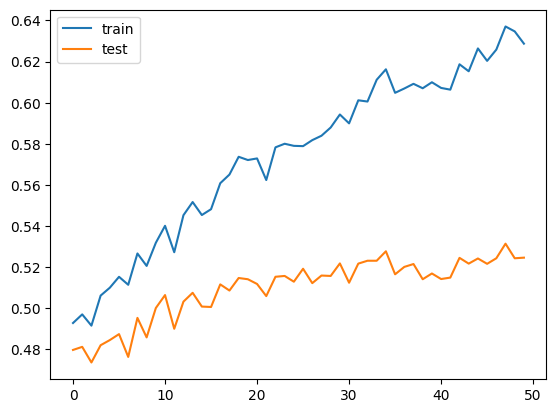

In [13]:
import numpy as np

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()


n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_train_loss = 0.
  total_test_loss = 0.
  train_loss = 0.
  test_loss = 0.

  model.train()
  for data in trainloader:
    # train
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    preds = model(inputs)
    loss = nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()


  with torch.no_grad():
    model.eval()

    for data in testloader:
      # test
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')
      preds = model(inputs)
      loss = nn.CrossEntropyLoss()(preds, labels)

      total_test_loss += loss.item()


    train_accuracy = accuracy(model, trainloader)
    test_accuracy = accuracy(model, testloader)

    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)


  print(f"Epoch {epoch:3d} | Train Accuracy: {train_accuracy * 100 :.4f}% | Test Accuracy: {test_accuracy * 100:.4f}%")
  print(f"Epoch {epoch:3d} | Train Loss: {total_train_loss / len(trainloader.dataset)*100  :.4f}% | Test Loss: {total_test_loss / len(trainloader.dataset)*100:.4f}%")

plot_acc(train_accs, test_accs)



출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.